In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from resnet import Resnet4Channel

In [3]:
gpu_device = 1

defaults.device = torch.device(f'cuda:{gpu_device}')
torch.cuda.set_device(gpu_device)

In [4]:
bs = 64

In [5]:
path = Path('/home/haider/data/human_protein_atlas/')

In [6]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [7]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [8]:
src.train.x.create_func

AttributeError: 'ImageItemList' object has no attribute 'create_func'

In [10]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [11]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [12]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [13]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [14]:
test_fnames[:5]

[PosixPath('/home/haider/data/human_protein_atlas/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [15]:
src.add_test(test_fnames, label='0');

In [16]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [17]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [18]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [19]:
data = (src.transform((trn_tfms, _), size=224)
        .databunch().normalize(protein_stats))

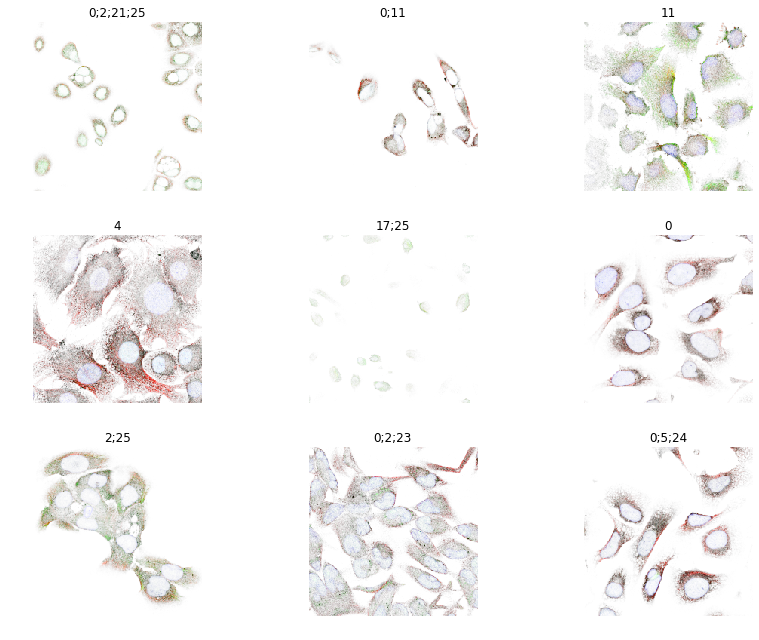

In [20]:
data.show_batch(rows=3, figsize=(12,9))

In [21]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [25]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): 
    # import pdb; pdb.set_trace()  ; m[0] returns the body ; m[0][6] returns the 7th block of the body ; m[1] returns the head; 
    # so it seems this function specifies the points that divides the 3 groups for the differential learning rates
    return (m[0][6],m[1])

In [26]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [27]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


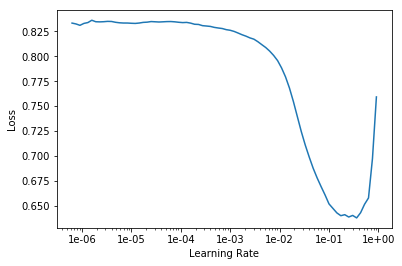

In [29]:
learn.recorder.plot()

In [30]:
lr = 3e-2

In [31]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,0.140606,0.132012,0.528804
2,0.134214,0.141339,0.523461


KeyboardInterrupt: 

In [ ]:
learn.save('stage-1-rn50-datablocks')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15, slice(3e-5, lr/5))

In [31]:
learn.save('stage-2-rn50')

In [32]:
preds,_ = learn.get_preds(DatasetType.Test)

/home/william/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [33]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)